# Synthetic Circular data with static place fields for hippocampal dataset

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cebra


# Set random seed for reproducibility
np.random.seed(42)

## Set synthetic parameters and simulate gain change, also plot the neural activity over time

In [8]:
# Parameters
track_radius = 100  # cm
n_laps = 10
n_positions_per_lap = 100
n_timesteps = n_laps * n_positions_per_lap
n_neurons = 50
noise_level = 0.1

# Generate rat's angular position for multiple laps
angular_position = np.linspace(0, 2*np.pi*n_laps, n_timesteps, endpoint=False)

# # Convert angular position to x, y coordinates
# rat_x = track_radius * np.cos(angular_position % (2*np.pi))
# rat_y = track_radius * np.sin(angular_position % (2*np.pi))

# Generate place fields for each neuron (in radians)
place_fields = np.random.uniform(0, 2*np.pi, n_neurons) #uniformly spread out place fields
field_widths = np.random.uniform(np.radians(30), np.radians(60), n_neurons) #widths of the field

# Generate neural activity based on rat position
neural_data = np.zeros((n_timesteps, n_neurons)) #make array N timesteps x n_neurons
for i in range(n_neurons):
    # Calculate the angular distance between the rat and each place field
    angular_distance = np.minimum(
        np.abs((angular_position % (2*np.pi)) - place_fields[i]),
        2*np.pi - np.abs((angular_position % (2*np.pi)) - place_fields[i])
    )
    #print(angular_distance.shape)
    # Gaussian curve based on angular distance
    neural_data[:, i] = np.exp(-(angular_distance**2) / (2 * field_widths[i]**2))

# Add noise
neural_data += np.random.normal(0, noise_level, neural_data.shape)
neural_data = np.maximum(neural_data, 0)  # non-negative firing



# Print some sample data
print(f"Total number of timesteps: {n_timesteps}")
# print(f"Rat x positions (first 5): {rat_x[:5]}")
# print(f"Rat y positions (first 5): {rat_y[:5]}")
# print(f"Rat x positions (last 5): {rat_x[-5:]}")
# print(f"Rat y positions (last 5): {rat_y[-5:]}")
print(f"Place fields (radians, first 5): {place_fields[:5]}")
print(f"Field widths (radians, first 5): {field_widths[:5]}")
print(f"Neural data shape: {neural_data.shape}")
print(f"Neural data sample (first 5 timesteps, first 3 neurons):\n{neural_data[:5, :3]}")
print(f"Neural data sample (last 5 timesteps, first 3 neurons):\n{neural_data[-5:, :3]}")

# Calculate the true 1D position (unwrapped)
true_1d_position = angular_position * track_radius

Total number of timesteps: 1000
Place fields (radians, first 5): [2.35330497 5.97351416 4.59925358 3.76148219 0.98029403]
Field widths (radians, first 5): [1.0312721  0.92945737 1.01551927 0.99212928 0.83665847]
Neural data shape: (1000, 50)
Neural data sample (first 5 timesteps, first 3 neurons):
[[0.08270888 0.91610893 0.26206376]
 [0.         0.86620029 0.23775783]
 [0.09830488 1.04146736 0.17793831]
 [0.11687218 0.75842933 0.11118557]
 [0.1451857  0.77345275 0.16968524]]
Neural data sample (last 5 timesteps, first 3 neurons):
[[0.         0.97745737 0.51656022]
 [0.07587625 0.79735857 0.42090416]
 [0.13399671 1.16604492 0.38330961]
 [0.08219908 0.96132113 0.46082882]
 [0.         0.88926666 0.31957989]]


## Taking a look at a couple neurons and their spike rates over the trial

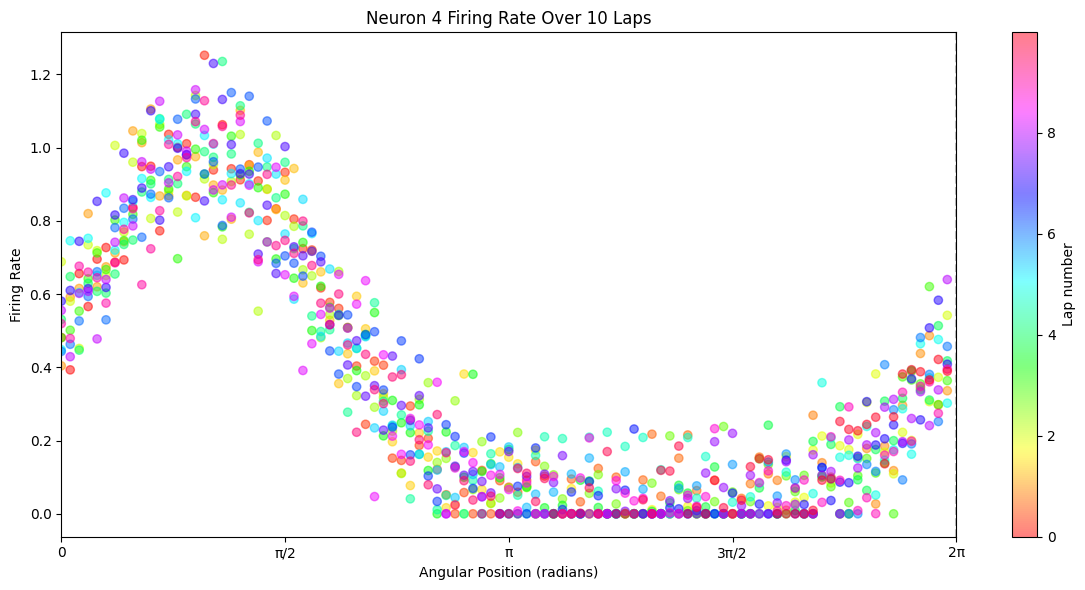

Place field center for neuron 4: 0.98 radians
Place field width for neuron 4: 0.84 radians


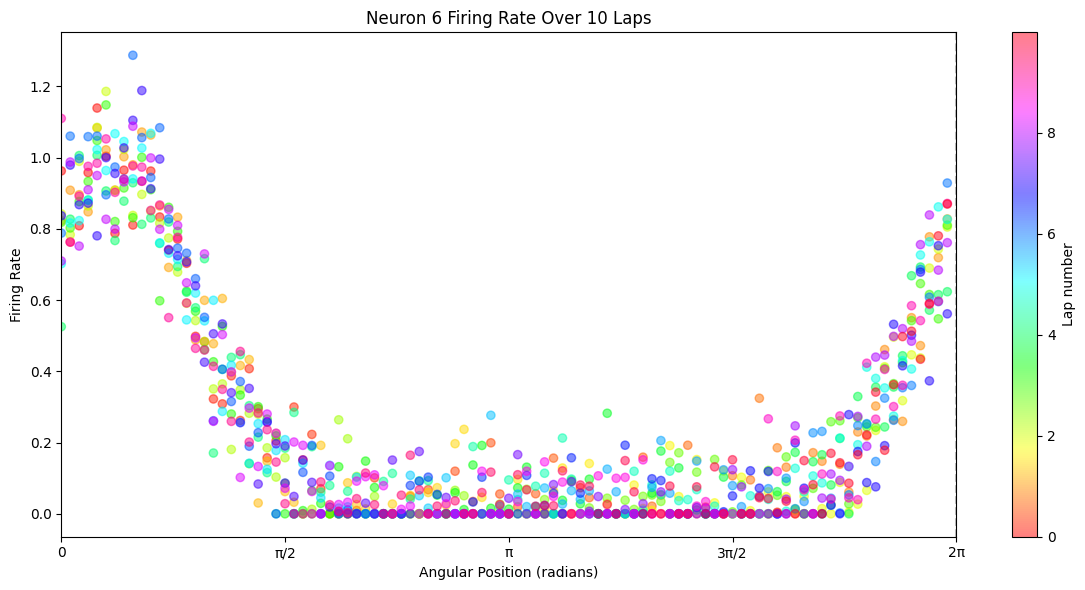

Place field center for neuron 6: 0.36 radians
Place field width for neuron 6: 0.57 radians


In [9]:
neuron_index = [4,6]


for neuron in neuron_index:

        # Extract the firing rate for the chosen neuron
    neuron_firing_rate = neural_data[:, neuron]

    # Create an array for the x-axis (angular position)
    angular_position_plot = angular_position % (2*np.pi)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.scatter(angular_position_plot, neuron_firing_rate, c=angular_position / (2*np.pi), 
                cmap='hsv', alpha=0.5)
    plt.colorbar(label='Lap number')
    plt.xlabel('Angular Position (radians)')
    plt.ylabel('Firing Rate')
    plt.title(f'Neuron {neuron} Firing Rate Over {n_laps} Laps')
    plt.xlim(0, 2*np.pi)
    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
            ['0', 'π/2', 'π', '3π/2', '2π'])

    # Add vertical lines to separate laps
    for lap in range(1, n_laps):
        plt.axvline(x=lap*2*np.pi, color='gray', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    print(f"Place field center for neuron {neuron}: {place_fields[neuron]:.2f} radians")
    print(f"Place field width for neuron {neuron}: {field_widths[neuron]:.2f} radians")

## Plot neural activity over time

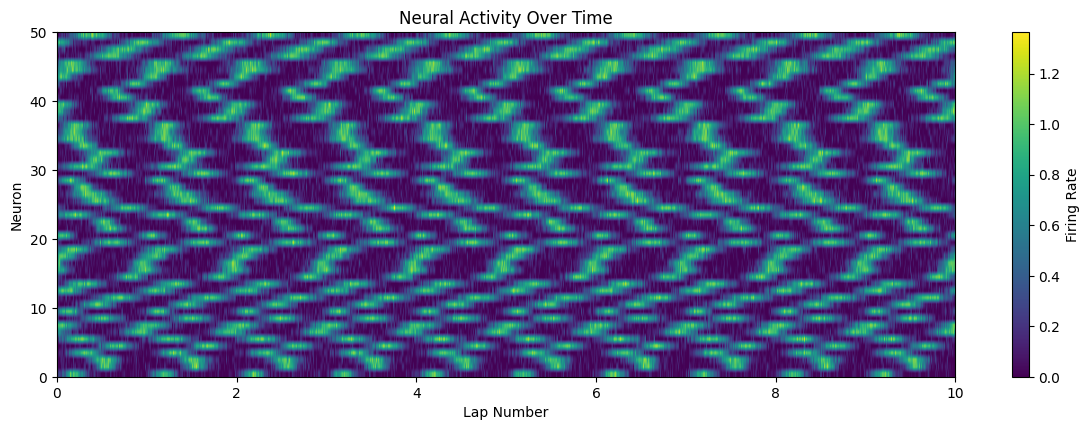

Shape of neural data: (1000, 50)
Mean firing rate: 0.327
Max firing rate: 1.365


In [10]:
# Plotting
plt.figure(figsize=(12, 8))

# Plot neural activity
plt.subplot(211)
plt.imshow(neural_data.T, aspect='auto', cmap='viridis', 
           extent=[0, n_laps, 0, n_neurons])
plt.colorbar(label='Firing Rate')
plt.title('Neural Activity Over Time')
plt.xlabel('Lap Number')
plt.ylabel('Neuron')


plt.tight_layout()
plt.show()

# Print some statistics
print(f"Shape of neural data: {neural_data.shape}")
print(f"Mean firing rate: {neural_data.mean():.3f}")
print(f"Max firing rate: {neural_data.max():.3f}")

## Embed in 2D and plot

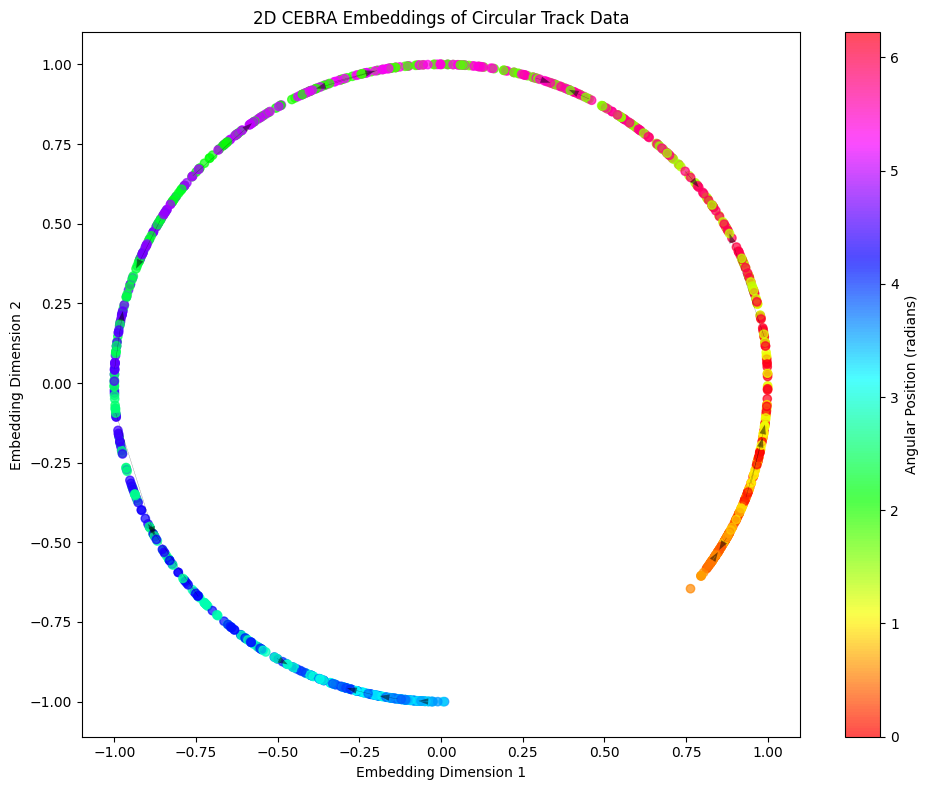

Embedding shape: (1000, 2)
Min values: [-0.9999947  -0.99997985]
Max values: [0.99996418 0.99999952]


In [11]:
# Create and fit the CEBRA model
model = cebra.CEBRA(output_dimension=2, batch_size=512, learning_rate=3e-4, max_iterations=1000)
model.fit(neural_data)

# Transform the data to get the embeddings
embeddings = model.transform(neural_data)

# Create the plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings[:, 0], 
                      embeddings[:, 1], 
                      c=angular_position % (2*np.pi), 
                      cmap='hsv',
                      alpha=0.7)

plt.colorbar(scatter, label='Angular Position (radians)')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('2D CEBRA Embeddings of Circular Track Data')

# Add some arrows to show the direction of movement
arrow_indices = np.linspace(0, len(embeddings)-1, 20, dtype=int)
for i in arrow_indices:
    if i+1 < len(embeddings):
        plt.arrow(embeddings[i, 0], embeddings[i, 1], 
                  embeddings[i+1, 0] - embeddings[i, 0], 
                  embeddings[i+1, 1] - embeddings[i, 1], 
                  shape='full', lw=0, length_includes_head=True, 
                  head_width=0.02, color='black', alpha=0.5)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Embedding shape: {embeddings.shape}")
print(f"Min values: {embeddings.min(axis=0)}")
print(f"Max values: {embeddings.max(axis=0)}")

## Now Embed in 3D and plot

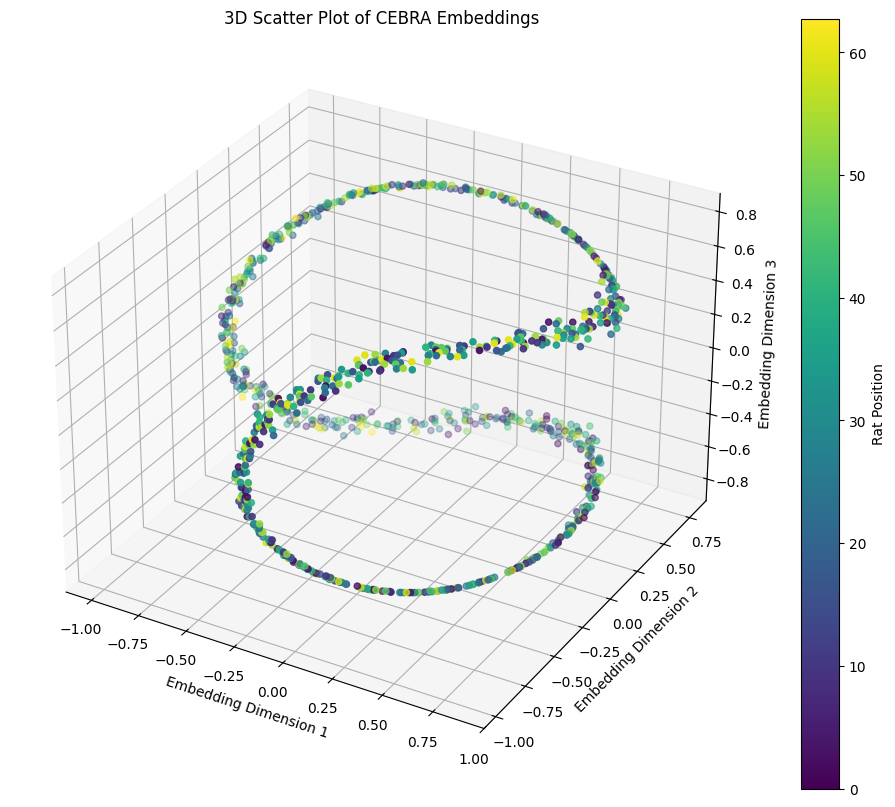

In [12]:
model = cebra.CEBRA(output_dimension=3, batch_size=512, learning_rate=3e-4, max_iterations=1000)
model.fit(neural_data)
embeddings = model.transform(neural_data)

from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embeddings[:, 0], 
                     embeddings[:, 1], 
                     embeddings[:, 2], 
                     c=angular_position, 
                     cmap='viridis')

ax.set_xlabel('Embedding Dimension 1')
ax.set_ylabel('Embedding Dimension 2')
ax.set_zlabel('Embedding Dimension 3')
ax.set_title('3D Scatter Plot of CEBRA Embeddings')

cbar = fig.colorbar(scatter, ax=ax, label='Rat Position')

plt.show()